In [39]:
from torchvision import datasets
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn 
from torch.optim import SGD, Adam
import matplotlib.ticker as mtick
from torch import optim

In [40]:
datafolder = '~/VSCode/#Programs/python/compre_design/data\FMNIST'

fmnist = datasets.FashionMNIST(datafolder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(datafolder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)


def getModel():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10),
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer


def getData():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl


def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()


@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [42]:
from torchsummary import summary

model, loss_fn, optimizer = getModel()
summary(model, torch.zeros(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [43]:
trn_dl, val_dl = getData()
model, loss_fn, optimizer = getModel()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0,threshold=0.001,verbose=True,min_lr=1e-5,threshold_mode='abs')

losses, accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(f"Current epoch: {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    for idx, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for idx, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    for idx, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
        scheduler.step(validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    print(f"the train loss: {epoch_loss}, the train accuracy: {epoch_accuracy}")
    print(f"the val loss: {validation_loss}, the val accuracy: {val_epoch_accuracy}")

Current epoch: 1
the train loss: 0.41971631529132525, the train accuracy: 0.8770166666666667
the val loss: 0.3683857023715973, the val accuracy: 0.8639
Current epoch: 2
the train loss: 0.2725590951263905, the train accuracy: 0.9224333333333333
the val loss: 0.2601335346698761, the val accuracy: 0.9049
Current epoch: 3
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
the train loss: 0.2238398407439391, the train accuracy: 0.9267
the val loss: 0.274306058883667, the val accuracy: 0.9023
Current epoch: 4
the train loss: 0.16650792672783135, the train accuracy: 0.9456333333333333
the val loss: 0.24387316405773163, the val accuracy: 0.9125
Current epoch: 5
the train loss: 0.14123103797212244, the train accuracy: 0.9587833333333333
the val loss: 0.2364303171634674, the val accuracy: 0.9173
Current epoch: 6
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
the train loss: 0.11997835039868951, the train accuracy: 0.96505
the val loss: 0.24765416979789734, the val accur

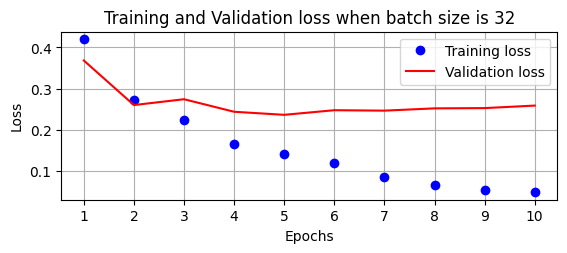

/tmp/ipykernel_8574/1872960083.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


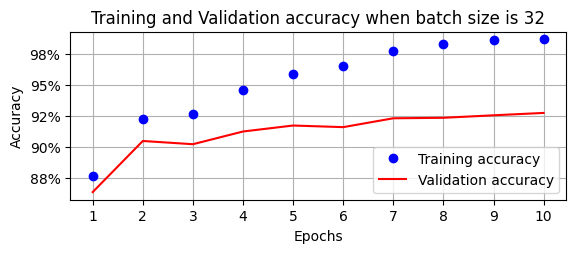

In [44]:
epochs = np.arange(10) + 1

# plt.figure(figsize=(20, 5))
# plt.subplot(121)
# plt.title('Loss value over increasing epochs')
# plt.plot(epochs, losses, label='Training Loss')
# plt.legend()

# plt.subplot(122)
# plt.title('accuracy value over increasing epochs')
# plt.plot(epochs, accuracies, label='Training Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# plt.legend()

plt.subplot(211)
plt.plot(epochs, losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

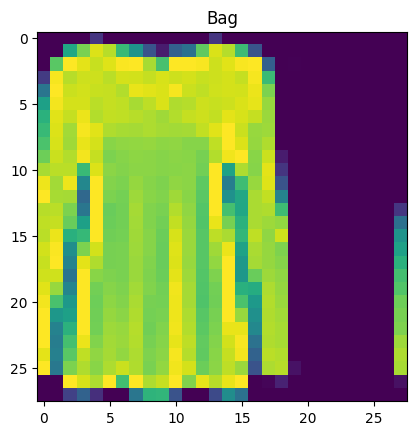

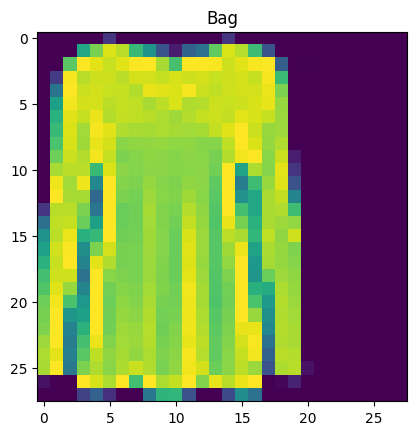

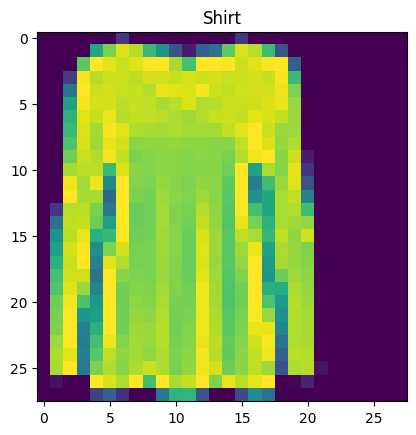

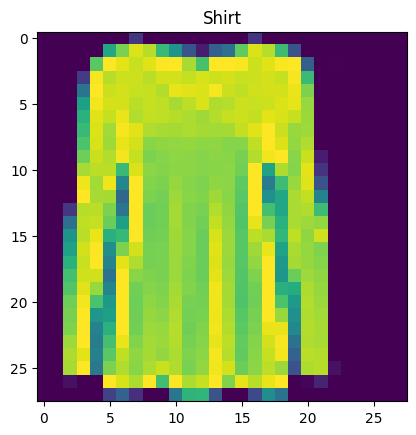

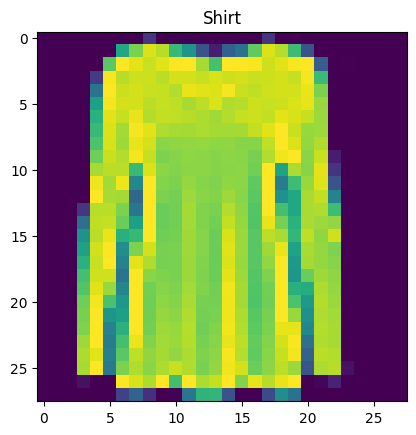

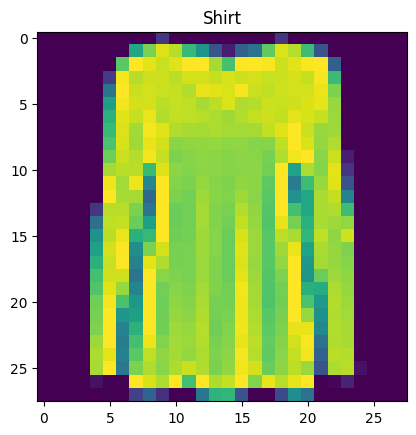

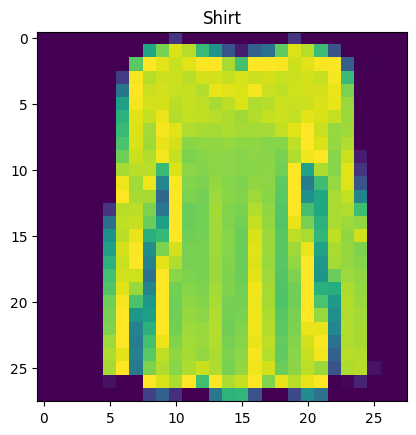

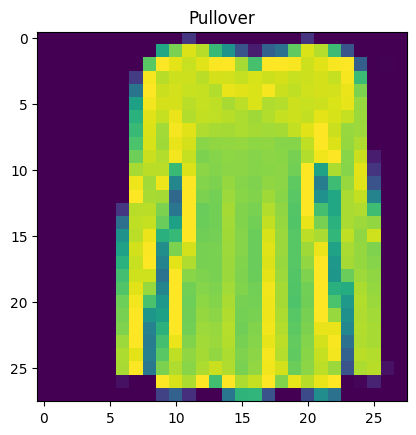

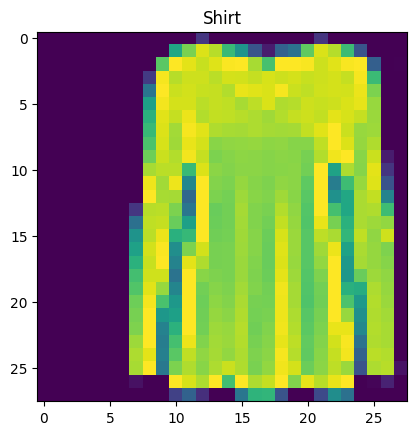

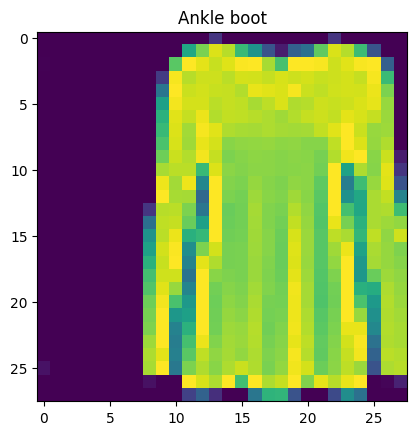

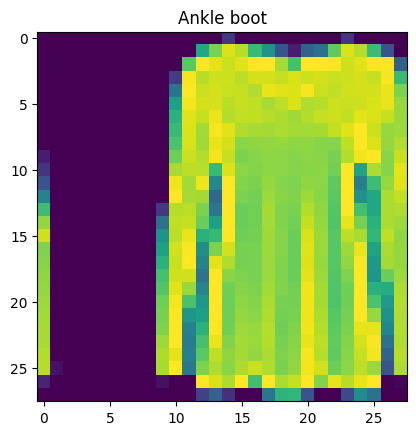

In [48]:
preds = []
idx = 12138
for px in range(-5, 6):
    img = tr_images[idx] / 255
    img = img.view(28,28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1, 1, 28, 28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output) / np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

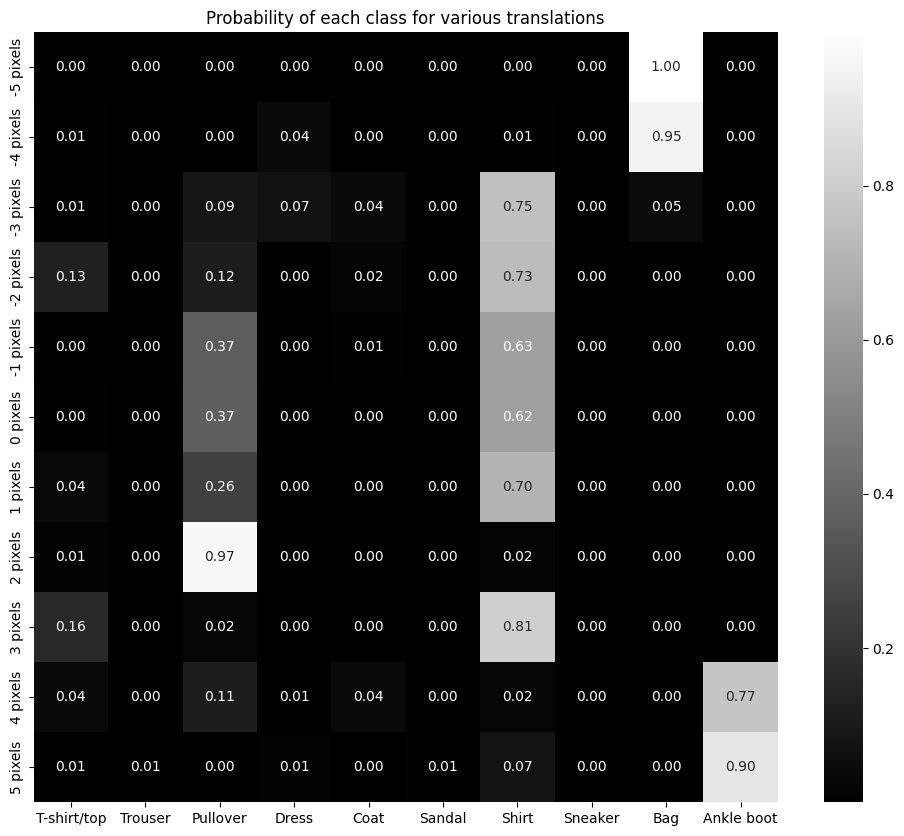

In [49]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title("Probability of each class for various translations")
sns.heatmap(
    np.array(preds).reshape(11, 10),
    annot=True,
    ax=ax,
    fmt=".2f",
    xticklabels=fmnist.classes,
    yticklabels=[str(i) + str(" pixels") for i in range(-5, 6)],
    cmap="gray",
)

In [ ]:
import imgaug.augmenters as iaa